# **Using All Genes**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Set plot style
sns.set_theme(style="whitegrid")

In [2]:
excel_path = os.path.join('Data', 'GSE196728_Peru_raw.xlsx')
try:
    df = pd.read_excel(excel_path)
    print("Excel file loaded successfully.")
    display(df.head())
    df.shape
except Exception as e:
    print(f"Error loading Excel file: {e}")

Excel file loaded successfully.


,Unnamed: 0,sub100_SL22.raw,sub101_SL18.raw,sub102_SL18.raw,sub103_SL10.raw,sub104_SL2.raw,sub10_SL22.raw,sub11_SL14.raw,sub12_SL2.raw,sub13_SL18.raw,...,sub67_RI2.raw,sub68_RI6.raw,sub69_RI2.raw,sub70_RI18.raw,sub7_RI14.raw,sub83_RI2.raw,sub85_RI2.raw,sub8_RI6.raw,sub98_RI14.raw,sub99_RI22.raw
0,A1BG-AS1,2,2,2,2,3,5,13,15,14,...,7,11,8,4,7,8,4,8,4,4
1,A2M-AS1,10,2,4,1,2,1,4,17,9,...,8,5,6,4,5,9,8,12,2,16
2,A4GALT,0,0,0,0,0,0,0,0,1,...,0,7,2,3,0,4,0,0,0,0
3,AAAS,23,7,14,15,20,47,33,85,47,...,37,32,43,21,87,48,30,78,12,35
4,AACS,12,7,11,7,7,8,23,37,25,...,25,27,21,13,23,17,14,24,10,19


In [3]:
pattern = re.compile(r'^sub(?P<subject>\d+)_SL(?P<time>\d+)\.raw$', re.IGNORECASE)
sample_columns = []
rename_map = {}
for col in df.columns:
    match = pattern.fullmatch(str(col))
    if match:
        sample_columns.append(col)
        subject = match.group('subject')
        timepoint = match.group('time')
        rename_map[col] = f"Sub{subject}_{timepoint}"

if 'Unnamed: 0' not in df.columns:
    raise KeyError("Expected 'Unnamed: 0' column was not found in the dataframe.")

columns_to_keep = ['Unnamed: 0'] + sample_columns
df = df.loc[:, columns_to_keep].rename(columns={'Unnamed: 0': 'Genes', **rename_map})
print(f"Filtered dataframe to {df.shape[0]} rows and {df.shape[1]} columns.")
display(df.head())
df.shape

Filtered dataframe to 12726 rows and 49 columns.


,Genes,Sub100_22,Sub101_18,Sub102_18,Sub103_10,Sub104_2,Sub10_22,Sub11_14,Sub12_2,Sub13_18,...,Sub79_6,Sub80_2,Sub86_14,Sub87_6,Sub88_22,Sub89_2,Sub92_2,Sub94_18,Sub95_18,Sub96_6
0,A1BG-AS1,2,2,2,2,3,5,13,15,14,...,8,3,10,3,2,10,5,5,6,5
1,A2M-AS1,10,2,4,1,2,1,4,17,9,...,9,2,19,3,4,13,1,5,3,4
2,A4GALT,0,0,0,0,0,0,0,0,1,...,0,0,1,0,2,0,0,0,4,0
3,AAAS,23,7,14,15,20,47,33,85,47,...,45,8,44,10,24,35,19,46,44,32
4,AACS,12,7,11,7,7,8,23,37,25,...,18,12,20,3,9,23,8,16,17,14


(12726, 49)

In [4]:
subject_pattern = re.compile(r'^Sub(?P<subject>\d+)_(?P<time>\d+)$')
subject_timepoints = {}
for col in df.columns:
    match = subject_pattern.match(str(col))
    if match:
        subj = match.group('subject')
        time = int(match.group('time'))
        subject_timepoints.setdefault(subj, set()).add(time)

for subj in sorted(subject_timepoints, key=lambda x: int(x)):
    times = sorted(subject_timepoints[subj])
    formatted_times = ','.join(str(t) for t in times)
    print(f'Subject {subj}: {formatted_times}')

Subject 1: 10
Subject 2: 6
Subject 3: 22
Subject 10: 22
Subject 11: 14
Subject 12: 2
Subject 13: 18
Subject 15: 6
Subject 16: 22
Subject 17: 18
Subject 18: 10
Subject 20: 14
Subject 21: 6
Subject 22: 14
Subject 23: 2
Subject 24: 22
Subject 33: 10
Subject 34: 14
Subject 36: 10
Subject 37: 14
Subject 38: 10
Subject 40: 10
Subject 57: 2
Subject 58: 10
Subject 59: 14
Subject 60: 18
Subject 62: 2
Subject 63: 18
Subject 73: 22
Subject 75: 6
Subject 76: 14
Subject 77: 6
Subject 78: 22
Subject 79: 6
Subject 80: 2
Subject 86: 14
Subject 87: 6
Subject 88: 22
Subject 89: 2
Subject 92: 2
Subject 94: 18
Subject 95: 18
Subject 96: 6
Subject 100: 22
Subject 101: 18
Subject 102: 18
Subject 103: 10
Subject 104: 2


In [5]:
time_counts = {}
for col in df.columns:
    match = subject_pattern.match(str(col))
    if match:
        time = int(match.group('time'))
        subj = match.group('subject')
        time_counts.setdefault(time, set()).add(subj)

for time in sorted(time_counts):
    subjects = time_counts[time]
    count = len(subjects)
    subject_list = ','.join(sorted(subjects, key=lambda x: int(x)))
    print(f'Time {time}: {count} subjects ({subject_list})')


Time 2: 8 subjects (12,23,57,62,80,89,92,104)
Time 6: 8 subjects (2,15,21,75,77,79,87,96)
Time 10: 8 subjects (1,18,33,36,38,40,58,103)
Time 14: 8 subjects (11,20,22,34,37,59,76,86)
Time 18: 8 subjects (13,17,60,63,94,95,101,102)
Time 22: 8 subjects (3,10,16,24,73,78,88,100)


## **“Do these cancer-related genes show similar time-of-day patterns across different people at sea level?”**

In [6]:
expr = df.copy()  # df after renaming, with 'Genes' + SubX_time columns
subject_pattern = re.compile(r'^Sub(?P<subject>\d+)_(?P<time>\d+)$')

meta_rows = []
for col in expr.columns:
    m = subject_pattern.match(col)
    if m:
        meta_rows.append({
            "sample": col,
            "subject": int(m.group("subject")),
            "time": int(m.group("time"))
        })

meta = pd.DataFrame(meta_rows)

In [7]:
reactome_path = os.path.join('Data', 'REACTOME_CIRCADIAN_CLOCK.v2025.1.Hs (1).tsv')
reactome_df = pd.read_csv(reactome_path, sep='\t', names=['STANDARD_NAME', 'VALUE'], header=0)
gene_symbols_row = reactome_df.loc[reactome_df['STANDARD_NAME'] == 'GENE_SYMBOLS', 'VALUE']
if gene_symbols_row.empty:
    raise ValueError('Could not locate GENE_SYMBOLS entry in the Reactome file.')
reactome_genes = [gene.strip() for gene in gene_symbols_row.iloc[0].split(',') if gene.strip()]

if 'Genes' not in df.columns:
    raise KeyError("Expected 'Genes' column to be present in the dataframe. Run the filtering cell first.")
dataset_genes = df['Genes'].astype(str).str.strip()
dataset_gene_set = set(dataset_genes)
reactome_gene_set = set(reactome_genes)
overlap_genes = sorted(dataset_gene_set & reactome_gene_set)

print(f'Total genes in dataset: {len(dataset_gene_set)}')
print(f'Total genes in Reactome set: {len(reactome_gene_set)}')
print(f'Intersecting genes: {len(overlap_genes)}')
display(pd.DataFrame({'Reactome_Circadian_Genes': overlap_genes}))

Total genes in dataset: 12726
Total genes in Reactome set: 112
Intersecting genes: 99


,Reactome_Circadian_Genes
0,ADRM1
1,ATF2
2,BHLHE40
3,BHLHE41
4,BTRC
...,...
94,TGS1
95,UBA52
96,UBB
97,UBC


In [8]:
if 'overlap_genes' not in locals():
    raise NameError('Run the Reactome overlap cell first to compute overlap_genes.')
# HardOverride overlap_genes
overlap_genes = pd.read_csv('Data/gene_names.csv', header=None).iloc[:, 0].tolist()
df_intersection = df[df['Genes'].isin(overlap_genes)].copy()
print(f'Intersection dataset shape: {df_intersection.shape}')
display(df_intersection.head())

Intersection dataset shape: (12726, 49)


,Genes,Sub100_22,Sub101_18,Sub102_18,Sub103_10,Sub104_2,Sub10_22,Sub11_14,Sub12_2,Sub13_18,...,Sub79_6,Sub80_2,Sub86_14,Sub87_6,Sub88_22,Sub89_2,Sub92_2,Sub94_18,Sub95_18,Sub96_6
0,A1BG-AS1,2,2,2,2,3,5,13,15,14,...,8,3,10,3,2,10,5,5,6,5
1,A2M-AS1,10,2,4,1,2,1,4,17,9,...,9,2,19,3,4,13,1,5,3,4
2,A4GALT,0,0,0,0,0,0,0,0,1,...,0,0,1,0,2,0,0,0,4,0
3,AAAS,23,7,14,15,20,47,33,85,47,...,45,8,44,10,24,35,19,46,44,32
4,AACS,12,7,11,7,7,8,23,37,25,...,18,12,20,3,9,23,8,16,17,14


In [9]:
if 'df_intersection' not in locals():
    raise NameError('Run the intersection cell first to compute df_intersection.')

expression_cols = [col for col in df_intersection.columns if col != 'Genes']
expr_matrix = df_intersection.set_index('Genes')[expression_cols]

log_expr = np.log2(expr_matrix + 1)
mean_per_gene = log_expr.mean(axis=1)
std_per_gene = log_expr.std(axis=1).replace(0, np.nan)
log_expr_z = log_expr.sub(mean_per_gene, axis=0).div(std_per_gene, axis=0)

long_expression = expr_matrix.reset_index().melt(id_vars='Genes', var_name='sample', value_name='expression')
long_log = log_expr.reset_index().melt(id_vars='Genes', var_name='sample', value_name='log_expression')
long_z = log_expr_z.reset_index().melt(id_vars='Genes', var_name='sample', value_name='log_zscore')
temporal_df = long_expression.merge(long_log, on=['Genes', 'sample']).merge(long_z, on=['Genes', 'sample'])

pattern = re.compile(r'^Sub(?P<subject>\d+)_(?P<time>\d+)$')
subject_matches = temporal_df['sample'].apply(lambda x: pattern.match(str(x)))
temporal_df['subject'] = subject_matches.apply(lambda m: m.group('subject') if m else None)
temporal_df['time'] = subject_matches.apply(lambda m: int(m.group('time')) if m else None)
temporal_df = temporal_df.rename(columns={'Genes': 'gene'})

print(f'Temporal dataframe shape: {temporal_df.shape}')
display(temporal_df.head())
temporal_df.shape
unique_genes = temporal_df['gene'].unique()

Temporal dataframe shape: (610848, 7)


,gene,sample,expression,log_expression,log_zscore,subject,time
0,A1BG-AS1,Sub100_22,2,1.584963,-1.028943,100,22
1,A2M-AS1,Sub100_22,10,3.459432,1.273804,100,22
2,A4GALT,Sub100_22,0,0.000000,-0.772055,100,22
3,AAAS,Sub100_22,23,4.584963,-0.516535,100,22
4,AACS,Sub100_22,12,3.700440,-0.187736,100,22


## **Test for time-of-day effects using ANOVA**

In [10]:
long_df = temporal_df[['gene', 'time', 'log_zscore']].dropna().rename(columns={'log_zscore': 'z_expr'})
results = []
for gene in long_df['gene'].unique():
    tmp = long_df[long_df['gene'] == gene]
    if tmp['time'].nunique() < 2:
        results.append({'gene': gene, 'p_time': float('nan')})
        continue
    model = ols('z_expr ~ C(time)', data=tmp).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    pval = anova_table.loc['C(time)', 'PR(>F)']
    results.append({'gene': gene, 'p_time': pval})

time_effects = pd.DataFrame(results).sort_values('p_time')
display(time_effects.head())

,gene,p_time
5191,KNL1,0.000147
2763,DMKN,0.000747
11443,TTC33,0.001262
5544,LINC02724,0.001761
10059,SNORA118,0.002544


## **Attempt to cluster time-dependent genes**

In [11]:
if 'temporal_df' not in locals() or 'time_effects' not in locals():
    raise NameError('Ensure temporal_df and time_effects are computed before clustering.')

pval_threshold = 0.05
sig_genes = time_effects[time_effects['p_time'] < pval_threshold]['gene']
print(f'Significant genes (p < {pval_threshold}): {len(sig_genes)}')

if sig_genes.empty:
    print('No significant genes found to cluster.')
else:
    times = sorted(temporal_df['time'].dropna().unique())
    mean_profiles = (temporal_df[temporal_df['gene'].isin(sig_genes)]
                     .groupby(['gene', 'time'])['log_zscore']
                     .mean()
                     .unstack())
    mean_profiles = mean_profiles.reindex(columns=times)
    mean_profiles = mean_profiles.apply(lambda row: row.fillna(row.mean()), axis=1).fillna(0)

    scaler = StandardScaler()
    scaled_profiles = scaler.fit_transform(mean_profiles)
    n_clusters = min(4, len(mean_profiles))
    if n_clusters < 2:
        print('Not enough genes for clustering (need at least 2).')
    else:
        clustering = AgglomerativeClustering(n_clusters=n_clusters)
        labels = clustering.fit_predict(scaled_profiles)
        cluster_df = (pd.DataFrame({'gene': mean_profiles.index, 'cluster': labels})
                      .merge(time_effects, on='gene', how='left')
                      .sort_values(['cluster', 'p_time']))
        print(f'Generated {n_clusters} clusters.')
        display(cluster_df)

Significant genes (p < 0.05): 158
Generated 4 clusters.


,gene,cluster,p_time
58,KNL1,0,0.000147
149,ZNF667-AS1,0,0.002975
40,FAM133B,0,0.004161
70,LOC100190986,0,0.008207
67,LINC02878,0,0.008666
...,...,...,...
104,SATB1-AS1,3,0.046378
100,RNF212,3,0.047169
72,LOC440700,3,0.048493
134,WDR12,3,0.048891


## **Cosinor-type analysis for circadian rhythmicity**

In [12]:
if 'temporal_df' not in locals():
    raise NameError('Run the temporal formatting cell first to compute temporal_df.')

long_df = temporal_df[['gene', 'time', 'log_zscore']].dropna().rename(columns={'log_zscore': 'z_expr'})
long_df = long_df[long_df['time'].notna()].copy()
long_df['phase_rad'] = 2 * np.pi * (long_df['time'] / 24.0)
long_df['cos_t'] = np.cos(long_df['phase_rad'])
long_df['sin_t'] = np.sin(long_df['phase_rad'])

results_cos = []
for gene in long_df['gene'].unique():
    tmp = long_df[long_df['gene'] == gene]
    if tmp['time'].nunique() < 2:
        results_cos.append({'gene': gene, 'amp': np.nan, 'phase': np.nan, 'p': np.nan})
        continue
    model = ols('z_expr ~ cos_t + sin_t', data=tmp).fit()
    beta_cos = model.params.get('cos_t', np.nan)
    beta_sin = model.params.get('sin_t', np.nan)
    amp = np.sqrt(beta_cos**2 + beta_sin**2) if np.isfinite(beta_cos) and np.isfinite(beta_sin) else np.nan
    phase = np.arctan2(-beta_sin, beta_cos) if np.isfinite(beta_cos) and np.isfinite(beta_sin) else np.nan
    pval = float(model.f_test('cos_t = sin_t = 0').pvalue)
    results_cos.append({'gene': gene, 'amp': amp, 'phase': phase, 'p': pval})

cos_df = pd.DataFrame(results_cos).sort_values('p')
display(cos_df.head())


,gene,amp,phase,p
2763,DMKN,0.796154,-2.053889,0.000151
9924,SLCO4A1,0.764309,2.939578,0.000345
10059,SNORA118,0.760219,0.326616,0.000383
11443,TTC33,0.747528,-2.834344,0.000521
10994,TMEM220,0.727042,-2.164163,0.000843


## **Attempt to cluster genes by circadian phase**

Generated 4 phase clusters for rhythmic genes.


,phase_cluster,mean_peak_hour,mean_amp,genes
0,0,11.873441,0.559218,"[SLCO4A1, TTC33, LOC100130872, RBBP8, HRAT92, ..."
1,1,16.462606,0.563901,"[DMKN, TMEM220, GAS8, TTC39C-AS1, C5orf63, SLC..."
2,2,6.474877,0.553691,"[C8G, FEM1A, NEU1, RECQL4, SKA3, CDCA3, NFE4, ..."
3,3,17.724848,0.560947,"[SNORA118, GTF2I, PUS7L, PRORSD1P, SEC14L2, AD..."


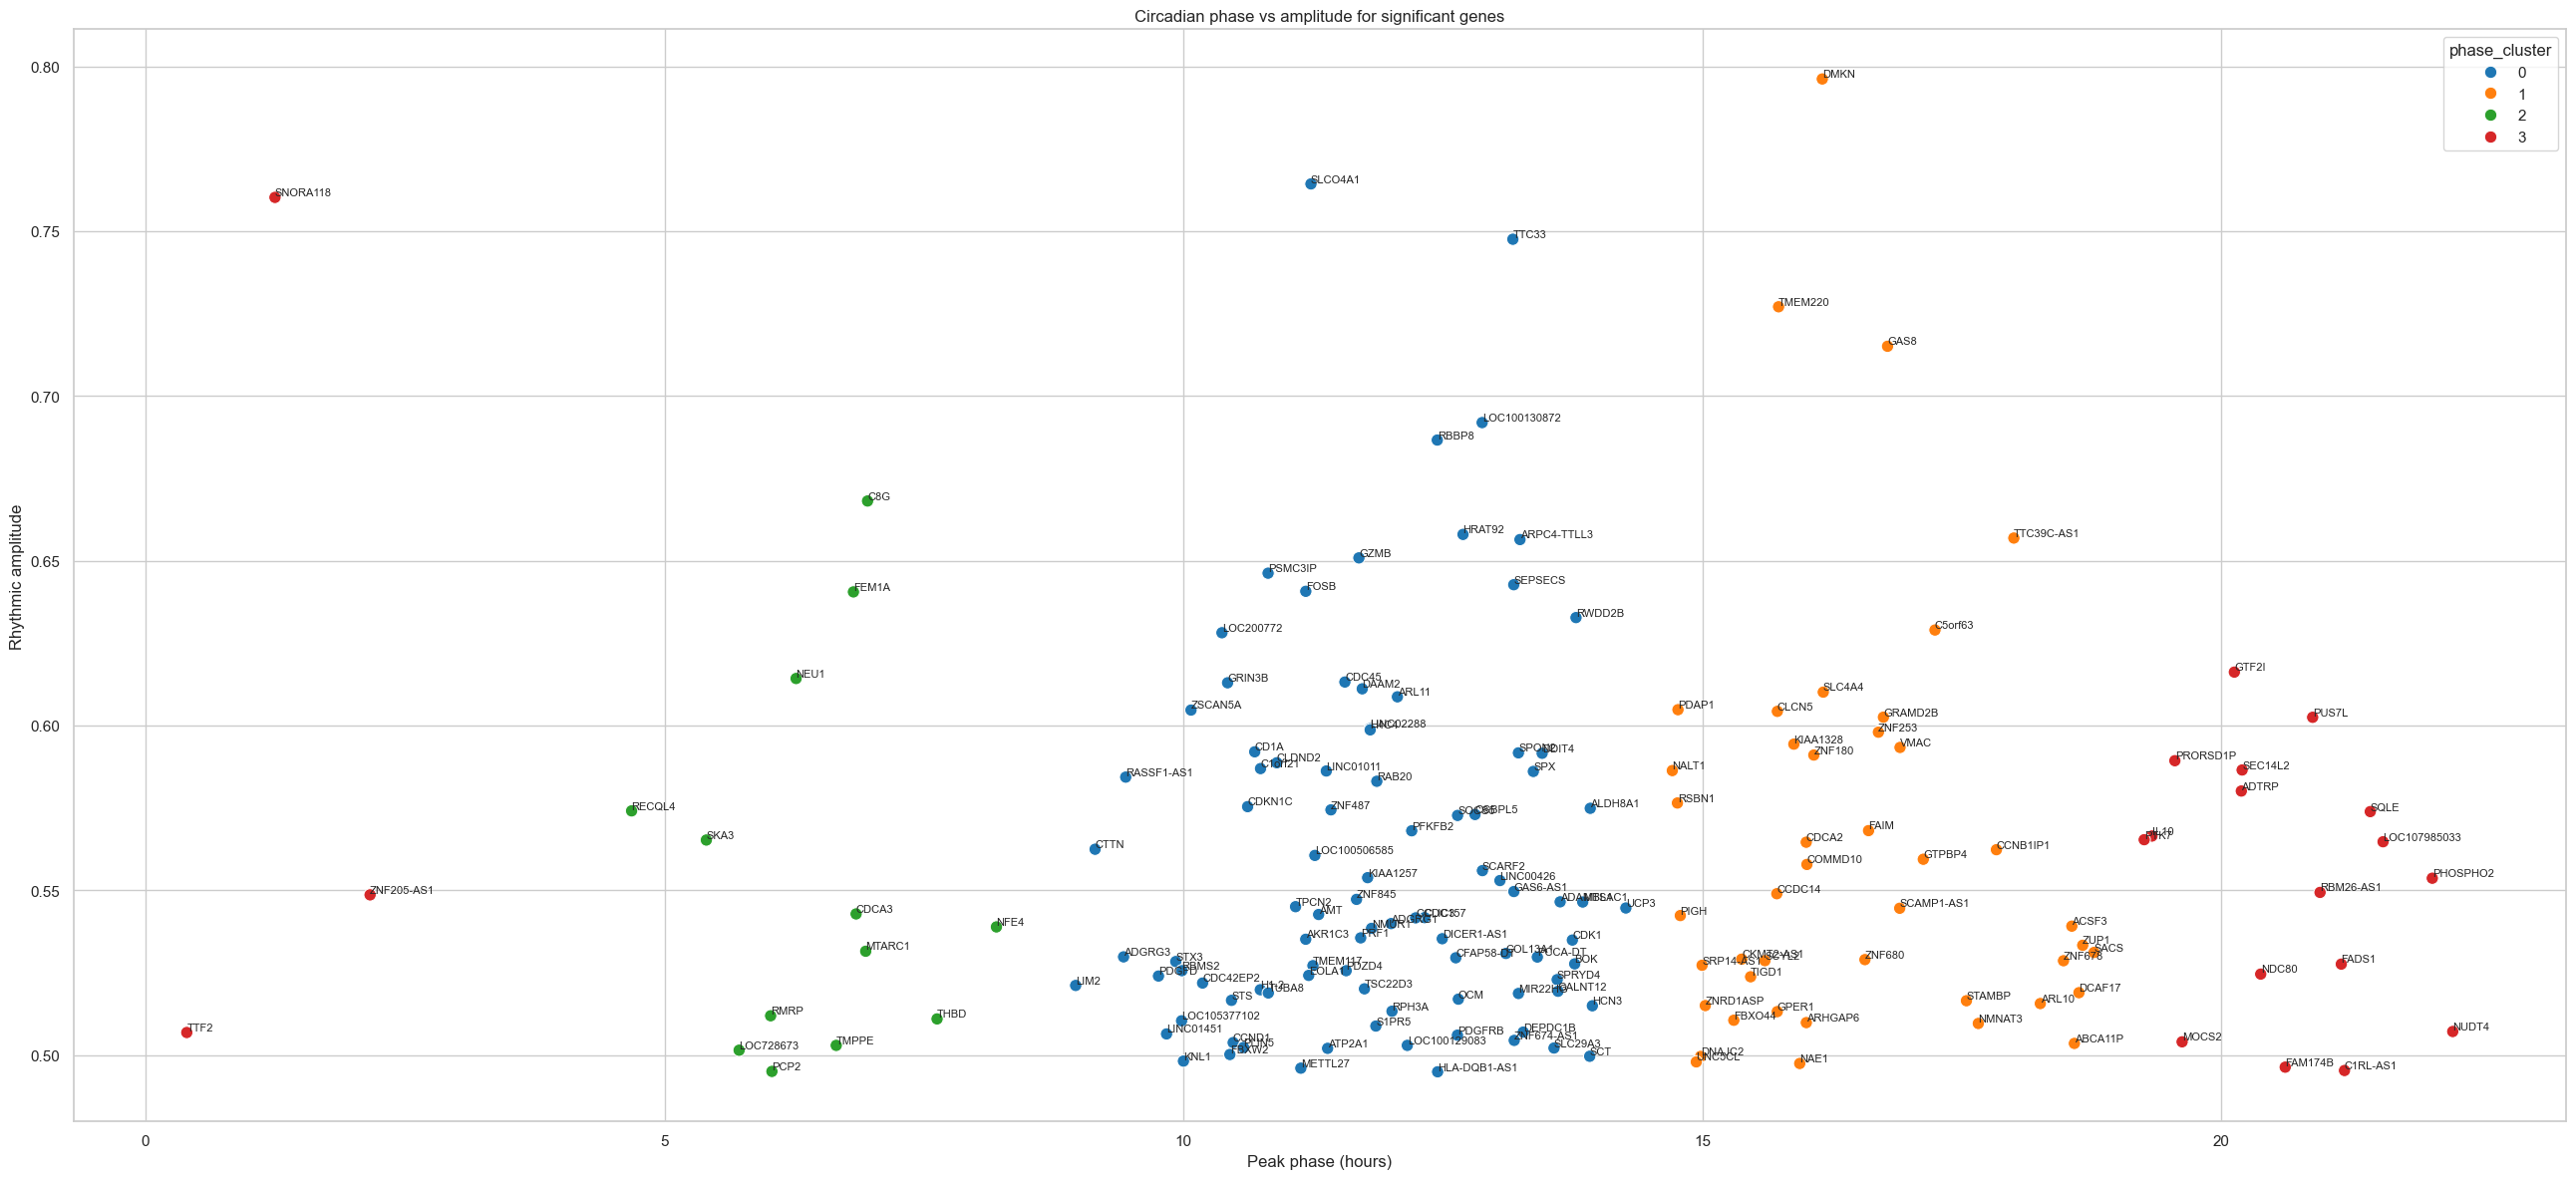

Saved phase/amplitude plot to Data/plots/circadian_phase_clusters.png


In [13]:
if 'cos_df' not in locals():
    raise NameError('Run the cosinor analysis cell first to compute cos_df.')

signif_threshold = 0.05
cos_sig = cos_df[(cos_df['p'] < signif_threshold) & cos_df['amp'].notna() & cos_df['phase'].notna()].copy()
if cos_sig.empty:
    print('No significant rhythmic genes to analyze for phase similarity.')
else:
    cos_sig['phase_wrapped'] = (cos_sig['phase'] % (2 * np.pi))
    cos_sig['peak_hour'] = (cos_sig['phase_wrapped'] / (2 * np.pi)) * 24
    cos_sig['cos_phase'] = np.cos(cos_sig['phase_wrapped'])
    cos_sig['sin_phase'] = np.sin(cos_sig['phase_wrapped'])
    n_clusters = min(4, len(cos_sig))
    if n_clusters < 2:
        cos_sig['phase_cluster'] = 0
        print('Fewer than two significant genes; skipping clustering.')
    else:
        clustering = AgglomerativeClustering(n_clusters=n_clusters)
        cos_sig['phase_cluster'] = clustering.fit_predict(cos_sig[['cos_phase', 'sin_phase']])
        print(f'Generated {n_clusters} phase clusters for rhythmic genes.')

    cluster_summary = (cos_sig.groupby('phase_cluster')
                       .agg(mean_peak_hour=('peak_hour', 'mean'),
                            mean_amp=('amp', 'mean'),
                            genes=('gene', lambda x: list(x)))
                       .reset_index())
    display(cluster_summary)

    plt.figure(figsize=(26, 12))
    sns.scatterplot(data=cos_sig, x='peak_hour', y='amp', hue='phase_cluster', palette='tab10', s=80)
    for _, row in cos_sig.iterrows():
        plt.text(row['peak_hour'], row['amp'], row['gene'], fontsize=8, ha='left', va='bottom')
    plt.xlabel('Peak phase (hours)')
    plt.ylabel('Rhythmic amplitude')
    plt.title('Circadian phase vs amplitude for significant genes')
    plt.tight_layout()
    plot_path = os.path.join('Data', 'plots', 'circadian_phase_clusters.png')
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
    plt.savefig(plot_path, dpi=150)
    plt.show()
    plt.close()
    print(f'Saved phase/amplitude plot to {plot_path}')

In [14]:
gene_time = (
    temporal_df
    .groupby(['gene', 'time'])['log_zscore']
    .mean()
    .unstack('time')         
)
corr_mat = gene_time.T.corr()

In [15]:
def get_gene_correlation(gene1, gene2, corr_mat):
    # track missing genes
    missing = []
    for g in [gene1, gene2]:
        if g not in corr_mat.index or g not in corr_mat.columns:
            missing.append(g)

    # handle missing cases
    if len(missing) == 2:
        print(f"Both genes are absent: {missing[0]} and {missing[1]}")
        return None
    if len(missing) == 1:
        print(f"Gene absent: {missing[0]}")
        return None

    # both present
    corr_value = corr_mat.loc[gene1, gene2]
    print(f"Correlation between {gene1} and {gene2}: {corr_value:.4f}")
    return None

get_gene_correlation("ARNTL", "NR1D1", corr_mat)

Correlation between ARNTL and NR1D1: 0.3954
